<a href="https://colab.research.google.com/github/iamnotahumanbecauseiamabot/graphs/blob/master/graph_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install dgl
#!pip install torch_geometric
#!pip install torch_sparse
#!pip install torch_scatter
#!pip install torch_cluster

     |████████████████████████████████| 2.4MB 9.2MB/s 


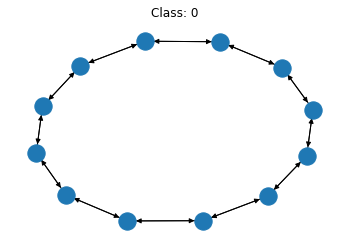

In [0]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
import dgl

#create a graph
dataset = MiniGCDataset(80, 10, 20)
graph, label = dataset[0]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

In [0]:
def collate(samples):
    #to pack multiple samples in MiniGCDataset into a mini-batch.
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

In [0]:
import dgl.function as fn
import torch
import torch.nn as nn
msg = fn.copy_src(src='h', out='m')

In [0]:
def reduce(nodes):
    accum = torch.mean(nodes.mailbox['m'], 1)
    return {'h': accum}

In [0]:
class NodeApplyModule(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}

In [0]:
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCNLayer, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        g.ndata['h'] = feature
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

In [0]:
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.layers = nn.ModuleList([
            GCNLayer(in_dim, hidden_dim, F.relu),
            GCNLayer(hidden_dim, hidden_dim, F.relu)])
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        h = g.in_degrees().view(-1, 1).float()
        for conv in self.layers:
            h = conv(g, h)
        g.ndata['h'] = h
        graph_repr = dgl.mean_nodes(g, 'h')
        return self.classify(graph_repr)

In [0]:
import torch.optim as optim
from torch.utils.data import DataLoader

trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)
data_loader = DataLoader(trainset, batch_size=32, shuffle=True,
                         collate_fn=collate)

In [0]:
model = Classifier(1, 256, trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

Classifier(
  (layers): ModuleList(
    (0): GCNLayer(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=1, out_features=256, bias=True)
      )
    )
    (1): GCNLayer(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
    )
  )
  (classify): Linear(in_features=256, out_features=8, bias=True)
)

In [0]:
epoch_losses = []
for epoch in range(80):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 0, loss 2.1593
Epoch 1, loss 1.9688
Epoch 2, loss 1.8584
Epoch 3, loss 1.7765
Epoch 4, loss 1.6813
Epoch 5, loss 1.5912
Epoch 6, loss 1.5267
Epoch 7, loss 1.4538
Epoch 8, loss 1.3824
Epoch 9, loss 1.3046
Epoch 10, loss 1.2823
Epoch 11, loss 1.2057
Epoch 12, loss 1.1526
Epoch 13, loss 1.1038
Epoch 14, loss 1.0569
Epoch 15, loss 1.0466
Epoch 16, loss 1.0159
Epoch 17, loss 0.9858
Epoch 18, loss 0.9613
Epoch 19, loss 0.9442
Epoch 20, loss 0.9356
Epoch 21, loss 0.8905
Epoch 22, loss 0.8933
Epoch 23, loss 0.8892
Epoch 24, loss 0.8505
Epoch 25, loss 0.8193
Epoch 26, loss 0.8280
Epoch 27, loss 0.8405
Epoch 28, loss 0.8072
Epoch 29, loss 0.8244
Epoch 30, loss 0.8190
Epoch 31, loss 0.7881
Epoch 32, loss 0.7644
Epoch 33, loss 0.7475
Epoch 34, loss 0.7349
Epoch 35, loss 0.7397
Epoch 36, loss 0.7346
Epoch 37, loss 0.7280
Epoch 38, loss 0.7000
Epoch 39, loss 0.6950
Epoch 40, loss 0.7284
Epoch 41, loss 0.7235
Epoch 42, loss 0.6691
Epoch 43, loss 0.6515
Epoch 44, loss 0.6747
Epoch 45, loss 0.664